In [2]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path

['/home/blessyantony/miniconda3/envs/zoonosis/lib/python311.zip',
 '/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11',
 '/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11/lib-dynload',
 '',
 '/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11/site-packages',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../..']

In [4]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pathlib import Path
import textwrap
from sklearn.metrics import roc_curve, accuracy_score, f1_score, auc, precision_recall_curve, precision_score, recall_score
from statistics import mean
from src.utils import utils, evaluation_utils, visualization_utils
from matplotlib.ticker import MultipleLocator

In [5]:
dataset_file_path = os.path.join(os.getcwd(), "..","..", "..", "input/data/uniref90/20240131/uniref90_viridae_embl_hosts_pruned_metadata_species_vertebrates_w_seq_idv.csv")
unseen_hosts_file_path = os.path.join(os.getcwd(), "..","..", "..", "input/data/uniref90/20240131/uniref90_viridae_embl_hosts_pruned_metadata_species_vertebrates_w_seq_idv_unseen_hosts.csv")
seen_hosts_file_path = os.path.join(os.getcwd(), "..","..", "..", "input/data/uniref90/20240131/uniref90_viridae_embl_hosts_pruned_metadata_species_vertebrates_w_seq_idv_seen_hosts.csv")

In [6]:
def compute_class_distribution(df, label_col, n, idv_seen_hosts, format=False):
    labels_counts = df[label_col].value_counts()
    print(labels_counts)
    labels_counts = labels_counts / n * 100
    labels_counts = labels_counts.to_dict()
    if format:
        labels_counts = {k: f"{k}\n(n={int(v/100*n)}, {v:.3f}%)" for k, v, in labels_counts.items()}
        
        for k, v in labels_counts.items():
            if k in idv_seen_hosts:
                labels_counts[k] = "*" + v
    return labels_counts

In [7]:
dataset_df = pd.read_csv(dataset_file_path)

In [8]:
idv_seen_hosts = set(pd.read_csv(seen_hosts_file_path)["virus_host_name"].unique())
idv_unseen_hosts = set(pd.read_csv(unseen_hosts_file_path)["virus_host_name"].unique())

In [9]:
metadata_formatted = compute_class_distribution(dataset_df, "virus_host_name", n=220068, idv_seen_hosts=idv_seen_hosts, format=True)
metadata_formatted

virus_host_name
Homo sapiens                          218631
Macaca mulatta                           849
Felis catus                              143
Cercocebus atys                          122
Puma concolor                             24
Macaca nemestrina                         23
Mandrillus sphinx                         23
Mandrillus leucophaeus                    20
Cercopithecus nictitans                   19
Cercopithecus solatus                     17
Cercocebus torquatus                      16
Cercopithecus aethiops                    14
Colobus guereza                           13
Cercopithecus cephus                      13
Chlorocebus sabaeus                       13
Cercopithecus neglectus                   12
Panthera leo                              12
Chlorocebus tantalus                      10
Cercopithecus mona                        10
Felis silvestris catus                     9
Cercopithecus lhoesti                      8
Chlorocebus pygerythrus                

{'Homo sapiens': '*Homo sapiens\n(n=218631, 99.347%)',
 'Macaca mulatta': '*Macaca mulatta\n(n=849, 0.386%)',
 'Felis catus': '*Felis catus\n(n=143, 0.065%)',
 'Cercocebus atys': 'Cercocebus atys\n(n=122, 0.055%)',
 'Puma concolor': 'Puma concolor\n(n=24, 0.011%)',
 'Macaca nemestrina': 'Macaca nemestrina\n(n=23, 0.010%)',
 'Mandrillus sphinx': '*Mandrillus sphinx\n(n=23, 0.010%)',
 'Mandrillus leucophaeus': 'Mandrillus leucophaeus\n(n=20, 0.009%)',
 'Cercopithecus nictitans': 'Cercopithecus nictitans\n(n=19, 0.009%)',
 'Cercopithecus solatus': 'Cercopithecus solatus\n(n=17, 0.008%)',
 'Cercocebus torquatus': 'Cercocebus torquatus\n(n=16, 0.007%)',
 'Cercopithecus aethiops': 'Cercopithecus aethiops\n(n=14, 0.006%)',
 'Colobus guereza': 'Colobus guereza\n(n=13, 0.006%)',
 'Cercopithecus cephus': 'Cercopithecus cephus\n(n=13, 0.006%)',
 'Chlorocebus sabaeus': 'Chlorocebus sabaeus\n(n=13, 0.006%)',
 'Cercopithecus neglectus': 'Cercopithecus neglectus\n(n=12, 0.005%)',
 'Panthera leo': 'Pa

In [10]:
metadata_unformatted = compute_class_distribution(dataset_df, "virus_host_name", n=220068, idv_seen_hosts=idv_seen_hosts, format=False)
metadata_unformatted

virus_host_name
Homo sapiens                          218631
Macaca mulatta                           849
Felis catus                              143
Cercocebus atys                          122
Puma concolor                             24
Macaca nemestrina                         23
Mandrillus sphinx                         23
Mandrillus leucophaeus                    20
Cercopithecus nictitans                   19
Cercopithecus solatus                     17
Cercocebus torquatus                      16
Cercopithecus aethiops                    14
Colobus guereza                           13
Cercopithecus cephus                      13
Chlorocebus sabaeus                       13
Cercopithecus neglectus                   12
Panthera leo                              12
Chlorocebus tantalus                      10
Cercopithecus mona                        10
Felis silvestris catus                     9
Cercopithecus lhoesti                      8
Chlorocebus pygerythrus                

{'Homo sapiens': 99.34702001199629,
 'Macaca mulatta': 0.3857898467746333,
 'Felis catus': 0.0649799152989076,
 'Cercocebus atys': 0.05543741025501209,
 'Puma concolor': 0.010905720050166313,
 'Macaca nemestrina': 0.01045131504807605,
 'Mandrillus sphinx': 0.01045131504807605,
 'Mandrillus leucophaeus': 0.009088100041805259,
 'Cercopithecus nictitans': 0.008633695039714997,
 'Cercopithecus solatus': 0.007724885035534471,
 'Cercocebus torquatus': 0.0072704800334442085,
 'Cercopithecus aethiops': 0.0063616700292636824,
 'Colobus guereza': 0.005907265027173419,
 'Cercopithecus cephus': 0.005907265027173419,
 'Chlorocebus sabaeus': 0.005907265027173419,
 'Cercopithecus neglectus': 0.005452860025083156,
 'Panthera leo': 0.005452860025083156,
 'Chlorocebus tantalus': 0.0045440500209026295,
 'Cercopithecus mona': 0.0045440500209026295,
 'Felis silvestris catus': 0.004089645018812368,
 'Cercopithecus lhoesti': 0.0036352400167221043,
 'Chlorocebus pygerythrus': 0.0031808350146318412,
 'Cercopit

In [11]:
metadata_formatted_reverse = {v: k for k, v in metadata_formatted.items()}
metadata_formatted_reverse

{'*Homo sapiens\n(n=218631, 99.347%)': 'Homo sapiens',
 '*Macaca mulatta\n(n=849, 0.386%)': 'Macaca mulatta',
 '*Felis catus\n(n=143, 0.065%)': 'Felis catus',
 'Cercocebus atys\n(n=122, 0.055%)': 'Cercocebus atys',
 'Puma concolor\n(n=24, 0.011%)': 'Puma concolor',
 'Macaca nemestrina\n(n=23, 0.010%)': 'Macaca nemestrina',
 '*Mandrillus sphinx\n(n=23, 0.010%)': 'Mandrillus sphinx',
 'Mandrillus leucophaeus\n(n=20, 0.009%)': 'Mandrillus leucophaeus',
 'Cercopithecus nictitans\n(n=19, 0.009%)': 'Cercopithecus nictitans',
 'Cercopithecus solatus\n(n=17, 0.008%)': 'Cercopithecus solatus',
 'Cercocebus torquatus\n(n=16, 0.007%)': 'Cercocebus torquatus',
 'Cercopithecus aethiops\n(n=14, 0.006%)': 'Cercopithecus aethiops',
 'Colobus guereza\n(n=13, 0.006%)': 'Colobus guereza',
 'Cercopithecus cephus\n(n=13, 0.006%)': 'Cercopithecus cephus',
 'Chlorocebus sabaeus\n(n=13, 0.006%)': 'Chlorocebus sabaeus',
 'Cercopithecus neglectus\n(n=12, 0.005%)': 'Cercopithecus neglectus',
 'Panthera leo\n(n=1

In [12]:
classes = list(metadata_unformatted.keys())
classes

['Homo sapiens',
 'Macaca mulatta',
 'Felis catus',
 'Cercocebus atys',
 'Puma concolor',
 'Macaca nemestrina',
 'Mandrillus sphinx',
 'Mandrillus leucophaeus',
 'Cercopithecus nictitans',
 'Cercopithecus solatus',
 'Cercocebus torquatus',
 'Cercopithecus aethiops',
 'Colobus guereza',
 'Cercopithecus cephus',
 'Chlorocebus sabaeus',
 'Cercopithecus neglectus',
 'Panthera leo',
 'Chlorocebus tantalus',
 'Cercopithecus mona',
 'Felis silvestris catus',
 'Cercopithecus lhoesti',
 'Chlorocebus pygerythrus',
 'Cercopithecus mitis',
 'Macaca fascicularis',
 'Felis domesticus',
 'Macaca arctoides',
 'Semnopithecus entellus',
 'Cercopithecus erythrotis',
 'Cercopithecus ascanius',
 'Bos taurus',
 'Miopithecus ogouensis',
 'Cercocebus torquatus atys',
 'Cercopithecus aethiops pygerythrus',
 'Lynx rufus',
 'Piliocolobus badius',
 'Piliocolobus tephrosceles',
 'Panthera pardus',
 'Papio ursinus',
 'Otocolobus manul',
 'Procolobus verus']

In [13]:
# filter the classes to include the classes in output


In [14]:
classes_order = {k:i for i, k in enumerate(classes)}
class_formatted_order = {val: classes_order[key] for key, val in metadata_formatted.items()}
print(classes_order)
print(class_formatted_order)

{'Homo sapiens': 0, 'Macaca mulatta': 1, 'Felis catus': 2, 'Cercocebus atys': 3, 'Puma concolor': 4, 'Macaca nemestrina': 5, 'Mandrillus sphinx': 6, 'Mandrillus leucophaeus': 7, 'Cercopithecus nictitans': 8, 'Cercopithecus solatus': 9, 'Cercocebus torquatus': 10, 'Cercopithecus aethiops': 11, 'Colobus guereza': 12, 'Cercopithecus cephus': 13, 'Chlorocebus sabaeus': 14, 'Cercopithecus neglectus': 15, 'Panthera leo': 16, 'Chlorocebus tantalus': 17, 'Cercopithecus mona': 18, 'Felis silvestris catus': 19, 'Cercopithecus lhoesti': 20, 'Chlorocebus pygerythrus': 21, 'Cercopithecus mitis': 22, 'Macaca fascicularis': 23, 'Felis domesticus': 24, 'Macaca arctoides': 25, 'Semnopithecus entellus': 26, 'Cercopithecus erythrotis': 27, 'Cercopithecus ascanius': 28, 'Bos taurus': 29, 'Miopithecus ogouensis': 30, 'Cercocebus torquatus atys': 31, 'Cercopithecus aethiops pygerythrus': 32, 'Lynx rufus': 33, 'Piliocolobus badius': 34, 'Piliocolobus tephrosceles': 35, 'Panthera pardus': 36, 'Papio ursinus':

In [15]:
dataset_df["virus_host_name"].nunique()

40

In [16]:
import math

def get_uniformly_divided_position_bins(positions, n_bins):
    bin_width = math.floor(len(positions)/n_bins)
    bins = []
    start = 0
    for i in range(n_bins):
        end = start + bin_width
        bins.append(positions[start:end])
        start = end
    return bins

In [17]:
def get_rank(row, all_output_labels):
    y_true = row["y_true"]
    ranks = row[all_output_labels].rank(ascending=False, method="min")
    return ranks[y_true]

def plot_rank_distribution(df):
    plt.clf()
    plt.figure(figsize=(10, 10))
    sns.set_theme()
    plt.rcParams['xtick.labelsize'] = 16
    plt.rcParams['ytick.labelsize'] = 16
    plt.rcParams.update({'font.size': 16})
    ax = sns.displot(df, x="y_true_rank", hue="y_true", kind="kde", fill=True)
    ax.set_xlabel("Rank based on Probability", fontsize=20)
    sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))

   # plt.legend(title="Classes", loc="upper right", fontsize=10)
    plt.show()    
    
def analyze_all_way_fsl_results(output_file_path, auprc_file_path):
    output_auprc_df = pd.read_csv(auprc_file_path, index_col=0)
    output_df = pd.read_csv(output_file_path, index_col=0)
    print(f"Number of unique classes in output_df = {output_auprc_df['class'].nunique()}")
    
    all_output_labels = list(output_df.columns)
    all_output_labels.remove("itr")
    all_output_labels.remove("y_true")
    print(f"Number of unique labels in output_df = {len(all_output_labels)}")
    
    sub_df = output_df[output_df["itr"] == 0]
    sub_df.drop(columns="itr", inplace=True)
    sub_df["y_true_rank"] = sub_df.apply(lambda x: get_rank(x, all_output_labels), axis=1)
    sub_df["y_true_rank_bin"] = sub_df.apply(get_rank_bin, axis=1)
    
    #plot_rank_distribution(sub_df.replace({"y_true": metadata_formatted}))
    
    print(f"Number of Unseen IDV hosts  =  {len(idv_unseen_hosts)}")
    print(f"Number of Seen IDV hosts  =  {len(idv_seen_hosts)}")
    
    output_df["y_pred"] = output_df[all_output_labels].idxmax(axis=1)
        
    classwise_prob_dfs = []
    
    for label in all_output_labels:
        class_prob_df = sub_df[[label, "y_true", "y_true_rank_bin", "y_true_rank"]][sub_df["y_true"] == label]
        class_prob_df = class_prob_df.rename(columns={label: "probability", "y_true": "class"})
        classwise_prob_dfs.append(class_prob_df)

    class_prob_df = pd.concat(classwise_prob_dfs)
    class_prob_df.replace({"class": metadata_formatted}, inplace=True)
    
    #plot_probability_distribution(class_prob_df, 1/len(all_output_labels))
    return class_prob_df, 1/len(all_output_labels), idv_seen_hosts, idv_unseen_hosts


In [18]:
def plot_probability_distribution_stripplot_barplot(class_prob_df, random_predictor, rank_bins, output_file_path=None):
    n = len(rank_bins)
    # color_palette = sns.color_palette("ch:s=.25,rot=-.25_r", n_colors=n)
    color_palette = sns.color_palette("YlOrBr_r", n_colors=n)
    
    plt.clf()
    fig, ax = plt.subplots(1, 2, figsize=(20, 20), sharey=True)
    sns.set_theme(style="whitegrid")
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.labelsize'] = 20
    plt.rcParams['hatch.linewidth'] = 3
    plt.rcParams['hatch.color'] = "k" 
    plt.rcParams.update({'font.size': 20})
    class_prob_df.sort_values(by="class", key=lambda x: x.map(class_formatted_order), inplace=True)
    class_prob_df_hosts = list(class_prob_df["class"].unique())
    n_class_prob_df_hosts = len(class_prob_df_hosts)
    print(f"class_prob_df_hosts = {class_prob_df_hosts}")
    print(f"number of class_prob_df_hosts = {len(class_prob_df_hosts)}")
    
    sns.stripplot(data=class_prob_df, x="probability", y="class", hue="y_true_rank_bin",
                  palette=color_palette, hue_order=rank_bins, ax=ax[0], legend=False, size=10,
                 linewidth=.3)
    ax[0].axvline(random_predictor, color="gray", linestyle="--", linewidth=2)
    ax[0].set_ylabel("", fontsize=20)
    ax[0].set_xlabel("True Class Probability", fontsize=22)
    ax[0].set_xlim(0, 1)

    barplot_df = pd.crosstab(class_prob_df["class"], class_prob_df["y_true_rank_bin"], normalize="index")[rank_bins].cumsum(axis=1).stack().reset_index().rename(columns={0:"proportion"})
    barplot_df["percent"] = barplot_df["proportion"]*100

    sns.barplot(data=barplot_df, x="percent", y="class", hue="y_true_rank_bin", dodge=False, palette=color_palette[::-1], hue_order=rank_bins[::-1], ax=ax[1], edgecolor="k")
    ax[1].set_xlabel("Rank Distribution (%)", fontsize=22)

    plt.legend(title="Prediction", loc="upper right", fontsize=22)
    #sns.move_legend(ax[0], "lower center", ncol=6, title=None, bbox_to_anchor=(.9, 1), fontsize=16)
    sns.move_legend(ax[1], "lower center", ncol=6, title=None, bbox_to_anchor=(-0.08, 1), fontsize=16)
    plt.subplots_adjust(wspace = 0.05)
    if output_file_path:
        plt.savefig(output_file_path, bbox_inches="tight")
    plt.show()

In [19]:
def plot_probability_distribution_stripplot_barplot_landscape(class_prob_df, random_predictor, rank_bins, output_file_path=None):
    n = len(rank_bins)
    # color_palette = sns.color_palette("ch:s=.25,rot=-.25_r", n_colors=n)
    color_palette = sns.color_palette("YlOrBr_r", n_colors=n)
    
    plt.clf()
    fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
    sns.set_theme(style="whitegrid")
    plt.rcParams['xtick.labelsize'] = 18
    plt.rcParams['ytick.labelsize'] = 18
    plt.rcParams['hatch.linewidth'] = 3
    plt.rcParams['hatch.color'] = "k" 
    plt.rcParams.update({'font.size': 18})
    class_prob_df.sort_values(by="class", key=lambda x: x.map(class_formatted_order), inplace=True)
    class_prob_df_hosts = list(class_prob_df["class"].unique())
    n_class_prob_df_hosts = len(class_prob_df_hosts)
    print(f"class_prob_df_hosts = {class_prob_df_hosts}")
    print(f"number of class_prob_df_hosts = {len(class_prob_df_hosts)}")
    
    sns.stripplot(data=class_prob_df, y="probability", x="class", hue="y_true_rank_bin",
                  palette=color_palette, hue_order=rank_bins, ax=ax[1], legend=False, size=10,
                 linewidth=.3)
    ax[1].axhline(random_predictor, color="gray", linestyle="--", linewidth=2)
    ax[1].set_xlabel("", fontsize=0)
    ax[1].set_ylabel("True Class Probability", fontsize=18)
    ax[1].set_ylim(0, 1)

    barplot_df = pd.crosstab(class_prob_df["class"], class_prob_df["y_true_rank_bin"], normalize="index")[rank_bins].cumsum(axis=1).stack().reset_index().rename(columns={0:"proportion"})
    barplot_df["percent"] = barplot_df["proportion"]*100

    sns.barplot(data=barplot_df, y="percent", x="class", hue="y_true_rank_bin", dodge=False, palette=color_palette[::-1], hue_order=rank_bins[::-1], ax=ax[0], edgecolor="k", width=0.4)
    ax[0].set_ylabel("Rank Distribution (%)", fontsize=18)
    
    sns.move_legend(
        ax[0], "lower center",
        bbox_to_anchor=(0.5, 1.02), ncol=6, title=None, frameon=True, fontsize=18
    )
    #sns.move_legend(ax[1], "lower center", ncol=6, title=None, bbox_to_anchor=(-0.08, 1), fontsize=16)
    plt.subplots_adjust(hspace = 0.05)
    plt.xticks(rotation=90)
    if output_file_path:
        plt.savefig(output_file_path, bbox_inches="tight")
    plt.show()

In [20]:
def plot_probability_distribution_stripplot_lineplot(class_prob_df, rank_bins, output_file_path=None):
    n = len(rank_bins)
    # color_palette = sns.color_palette("ch:s=.25,rot=-.25_r", n_colors=n)
    color_palette = sns.color_palette("YlOrBr_r", n_colors=n)
    plt.clf()
    fig, ax = plt.subplots(1, 2, figsize=(27, 6), gridspec_kw={"width_ratios": [2.2, 1]})
    sns.set_theme(style="whitegrid")
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.labelsize'] = 20
    plt.rcParams.update({'font.size': 20})
    class_prob_df.sort_values(by="class", key=lambda x: x.map(class_formatted_order), inplace=True)
    class_prob_df_hosts = list(class_prob_df["class"].unique())
    n_class_prob_df_hosts = len(class_prob_df_hosts)
    print(f"class_prob_df_hosts = {class_prob_df_hosts}")
    print(f"number of class_prob_df_hosts = {len(class_prob_df_hosts)}")
    
    sns.stripplot(data=class_prob_df, y="probability", x="class", hue="y_true_rank_bin",
                  palette=color_palette, hue_order=rank_bins, ax=ax[0], size=10,
                 linewidth=.3)
    ax[0].axhline(random_predictor_23way, color="gray", linestyle="--", linewidth=3)
    ax[0].set_xlabel("", fontsize=0)
    ax[0].set_ylabel("True Class Probability", fontsize=20)
    ax[0].set_ylim(0, 1)
    ax[0].tick_params(labelrotation=90)
    
    barplot_df = pd.crosstab(class_prob_df["class"], class_prob_df["y_true_rank_bin"], normalize="index")[rank_bins].cumsum(axis=1).stack().reset_index().rename(columns={0:"proportion"})
    barplot_df["percent"] = barplot_df["proportion"]*100
    
    lineplot_dfs = []
    for rank in rank_bins:
        if rank == rank_bins[-1]: # ignore the last last bin
            continue
        curr_df = barplot_df[barplot_df["y_true_rank_bin"] == rank].sort_values("percent", ascending=False).reset_index(drop=True).reset_index()
        curr_df["index"] += 1
        lineplot_dfs.append(curr_df)
    lineplot_df = pd.concat(lineplot_dfs)
    #lineplot_df = barplot_df[["class", "y_true_rank_bin", "percent"]].groupby(["y_true_rank_bin", "percent"]).count().reset_index()
    sns.lineplot(data=lineplot_df, y="percent", x="index", hue="y_true_rank_bin", palette=color_palette, ax=ax[1], legend=False, linewidth=3)
    ax[1].set_xlabel("Cumulative Number \n of Classes", fontsize=20)
    ax[1].set_ylabel("Correct Predictions (%)", fontsize=20)
    ax[1].xaxis.set_major_locator(MultipleLocator(2))
    ax[1].yaxis.set_major_locator(MultipleLocator(10))
    ax[1].axhline(50, color="gray", linestyle="--", linewidth=3)
    #ax[1].axvline(3, color="gray", linestyle="--", linewidth=3)
    #sns.move_legend(ax[1], "lower center", ncol=6, title=None, bbox_to_anchor=(-0.08, 1), fontsize=16)
    plt.subplots_adjust(wspace = 0.12)
    ax[0].legend(fontsize=20)
    sns.move_legend(
        ax[0], "lower center",
        bbox_to_anchor=(.75, .98), ncol=n, title="True class in", frameon=False, title_fontsize=20,
        fontsize=20, markerscale=2
    )
    plt.text(x=-62, y=102, s="A", fontsize=24, color="black")
    plt.text(x=-4, y=102, s="B", fontsize=24, color="black")
    
    plt.savefig(output_file_path, bbox_inches="tight")
    plt.show()
    return lineplot_df


In [21]:
def plot_class_proportion_cumulative_nclasses(lineplot_df, rank_bins, output_file_path=None):
    n = len(rank_bins)
    # color_palette = sns.color_palette("ch:s=.25,rot=-.25_r", n_colors=n)
    color_palette = sns.color_palette("YlOrBr_r", n_colors=n)
    plt.clf()
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.set_theme(style="whitegrid")
    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14
    plt.rcParams.update({'font.size': 14})
    
    sns.lineplot(data=lineplot_df, y="percent", x="index", hue="y_true_rank_bin", palette=color_palette, ax=ax, linewidth=3)
    ax.set_xlabel("Cumulative Number \n of Classes", fontsize=14)
    ax.set_ylabel("Correct Predictions (%)", fontsize=14)
    ax.xaxis.set_major_locator(MultipleLocator(2))
    ax.yaxis.set_major_locator(MultipleLocator(10))
    ax.axhline(50, color="gray", linestyle="--", linewidth=3)
    ax.legend(fontsize=14)
    #sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    # sns.move_legend(
    #     ax, "lower center",
    #     bbox_to_anchor=(1, 1.01), ncol=int(n/2), title="True class in", frameon=False, title_fontsize=14,
    #     fontsize=14, markerscale=2
    # )
    plt.savefig(output_file_path, bbox_inches="tight")
    plt.show()

### Unseen hosts

#### 23-way

In [22]:
#output_file_path =  os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_idv_unseen_hosts/20241010/host_multi/few_shot_learning/fsl_tr_w5s3q10_te_walls3q-1_tsk1e1b16itr5_split70-10-20-gpu2_hybrid-attention_sl256st64vs30_ae_bn_fnn_2l_d1024_lr1e-4_output.csv")
#auprc_file_path =  os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_idv_unseen_hosts/20241010/host_multi/few_shot_learning/fsl_tr_w5s3q10_te_walls3q-1_tsk1e1b16itr5_split70-10-20-gpu2_hybrid-attention_sl256st64vs30_ae_bn_fnn_2l_d1024_lr1e-4_classwise_auprc.csv")
output_file_path =  os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_idv_all_hosts/20241022/host_multi/few_shot_learning/fsl_tr_w3s5q10_te_walls5q-1_tsk1e1b16itr5_split70-10-20-gpu2_hybrid-attention_sl256st64vs30_ae_bn_fnn_2l_d1024_lr1e-4_output.csv")
auprc_file_path =  os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_idv_all_hosts/20241022/host_multi/few_shot_learning/fsl_tr_w3s5q10_te_walls5q-1_tsk1e1b16itr5_split70-10-20-gpu2_hybrid-attention_sl256st64vs30_ae_bn_fnn_2l_d1024_lr1e-4_classwise_auprc.csv")

In [23]:
def get_rank_bin(row):
    rank = row["y_true_rank"]
    if rank == 1:
        return "Top rank"
    elif rank <= 3:
        return "Top 3 ranks"
    elif rank <= 5:
        return "Top 5 ranks"
    elif rank <= 10:
        return "Top 10 ranks"
    else:
        return "Rank > 10"
    
rank_bins = ["Top rank", "Top 3 ranks", "Top 5 ranks", "Top 10 ranks", "Rank > 10"]

In [24]:
class_prob_df_23way, random_predictor_23way, idv_seen_hosts, idv_unseen_hosts = analyze_all_way_fsl_results(output_file_path, auprc_file_path)

Number of unique classes in output_df = 23
Number of unique labels in output_df = 23


/tmp/ipykernel_707082/265477895.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df.drop(columns="itr", inplace=True)
/tmp/ipykernel_707082/265477895.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df["y_true_rank"] = sub_df.apply(lambda x: get_rank(x, all_output_labels), axis=1)
/tmp/ipykernel_707082/265477895.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Number of Unseen IDV hosts  =  32
Number of Seen IDV hosts  =  8


class_prob_df_hosts = ['*Homo sapiens\n(n=218631, 99.347%)', '*Macaca mulatta\n(n=849, 0.386%)', '*Felis catus\n(n=143, 0.065%)', 'Cercocebus atys\n(n=122, 0.055%)', 'Puma concolor\n(n=24, 0.011%)', 'Macaca nemestrina\n(n=23, 0.010%)', '*Mandrillus sphinx\n(n=23, 0.010%)', 'Mandrillus leucophaeus\n(n=20, 0.009%)', 'Cercopithecus nictitans\n(n=19, 0.009%)', 'Cercopithecus solatus\n(n=17, 0.008%)', 'Cercocebus torquatus\n(n=16, 0.007%)', 'Cercopithecus aethiops\n(n=14, 0.006%)', 'Colobus guereza\n(n=13, 0.006%)', 'Cercopithecus cephus\n(n=13, 0.006%)', 'Chlorocebus sabaeus\n(n=13, 0.006%)', 'Cercopithecus neglectus\n(n=12, 0.005%)', 'Panthera leo\n(n=12, 0.005%)', 'Chlorocebus tantalus\n(n=10, 0.005%)', 'Cercopithecus mona\n(n=10, 0.005%)', 'Felis silvestris catus\n(n=9, 0.004%)', 'Cercopithecus lhoesti\n(n=8, 0.004%)', 'Chlorocebus pygerythrus\n(n=7, 0.003%)', 'Cercopithecus mitis\n(n=6, 0.003%)']
number of class_prob_df_hosts = 23


<Figure size 640x480 with 0 Axes>

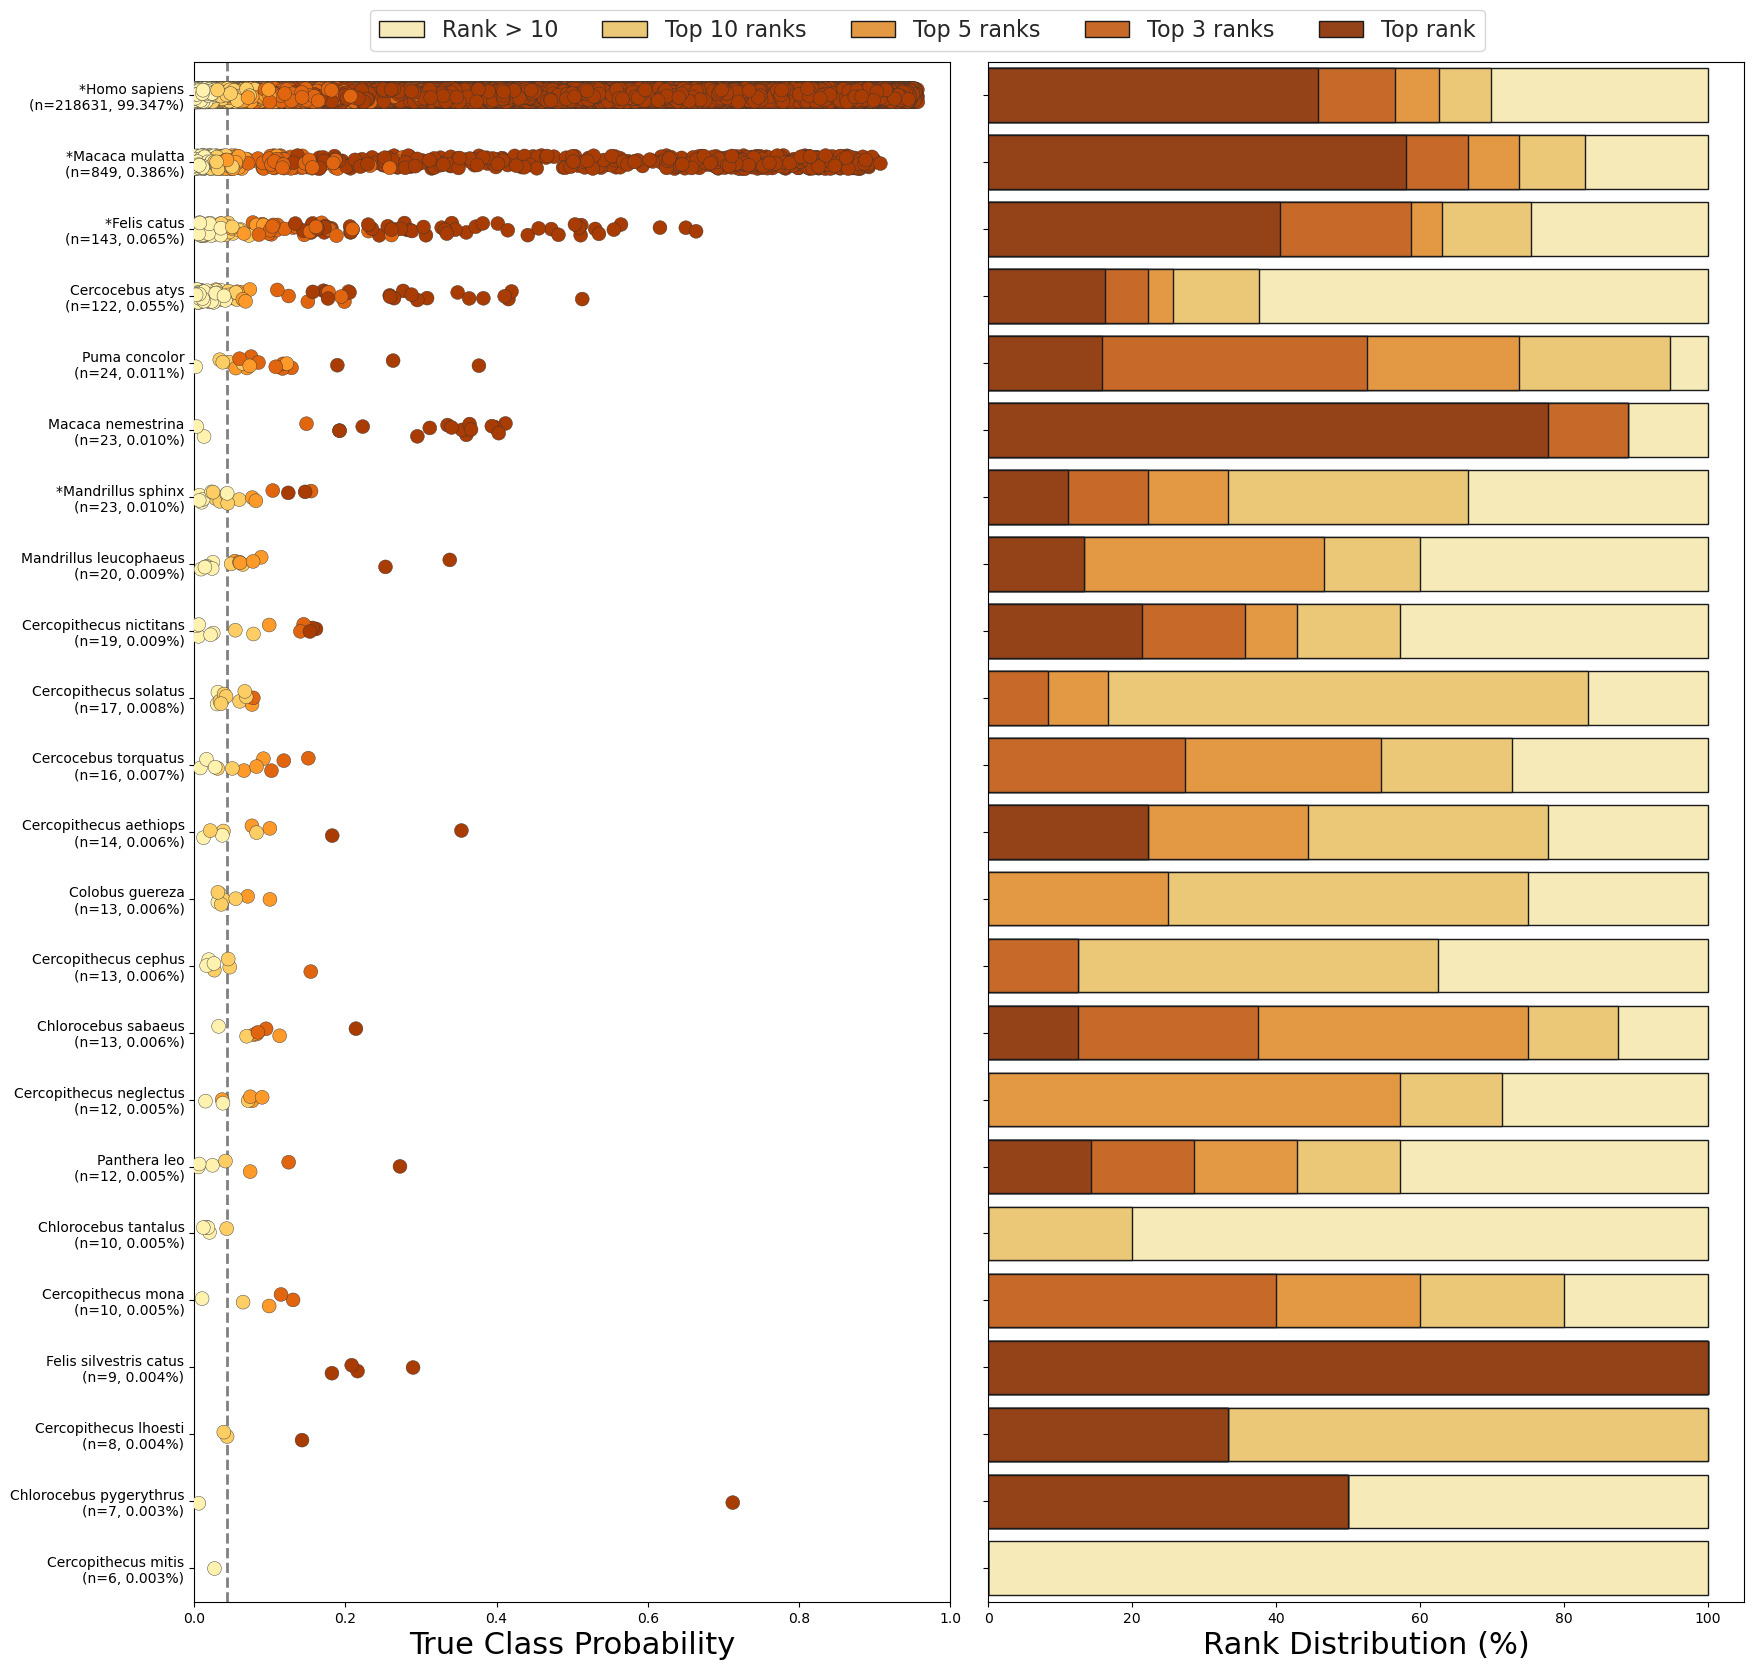

In [25]:
plot_probability_distribution_stripplot_barplot(class_prob_df_23way, random_predictor_23way, rank_bins, output_file_path = os.path.join(os.getcwd(), "..", "..", "..", f"output/visualization/temp_new/idv_fsl_23way.pdf"))

class_prob_df_hosts = ['*Homo sapiens\n(n=218631, 99.347%)', '*Macaca mulatta\n(n=849, 0.386%)', '*Felis catus\n(n=143, 0.065%)', 'Cercocebus atys\n(n=122, 0.055%)', 'Puma concolor\n(n=24, 0.011%)', 'Macaca nemestrina\n(n=23, 0.010%)', '*Mandrillus sphinx\n(n=23, 0.010%)', 'Mandrillus leucophaeus\n(n=20, 0.009%)', 'Cercopithecus nictitans\n(n=19, 0.009%)', 'Cercopithecus solatus\n(n=17, 0.008%)', 'Cercocebus torquatus\n(n=16, 0.007%)', 'Cercopithecus aethiops\n(n=14, 0.006%)', 'Colobus guereza\n(n=13, 0.006%)', 'Cercopithecus cephus\n(n=13, 0.006%)', 'Chlorocebus sabaeus\n(n=13, 0.006%)', 'Cercopithecus neglectus\n(n=12, 0.005%)', 'Panthera leo\n(n=12, 0.005%)', 'Chlorocebus tantalus\n(n=10, 0.005%)', 'Cercopithecus mona\n(n=10, 0.005%)', 'Felis silvestris catus\n(n=9, 0.004%)', 'Cercopithecus lhoesti\n(n=8, 0.004%)', 'Chlorocebus pygerythrus\n(n=7, 0.003%)', 'Cercopithecus mitis\n(n=6, 0.003%)']
number of class_prob_df_hosts = 23


/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

<Figure size 640x480 with 0 Axes>

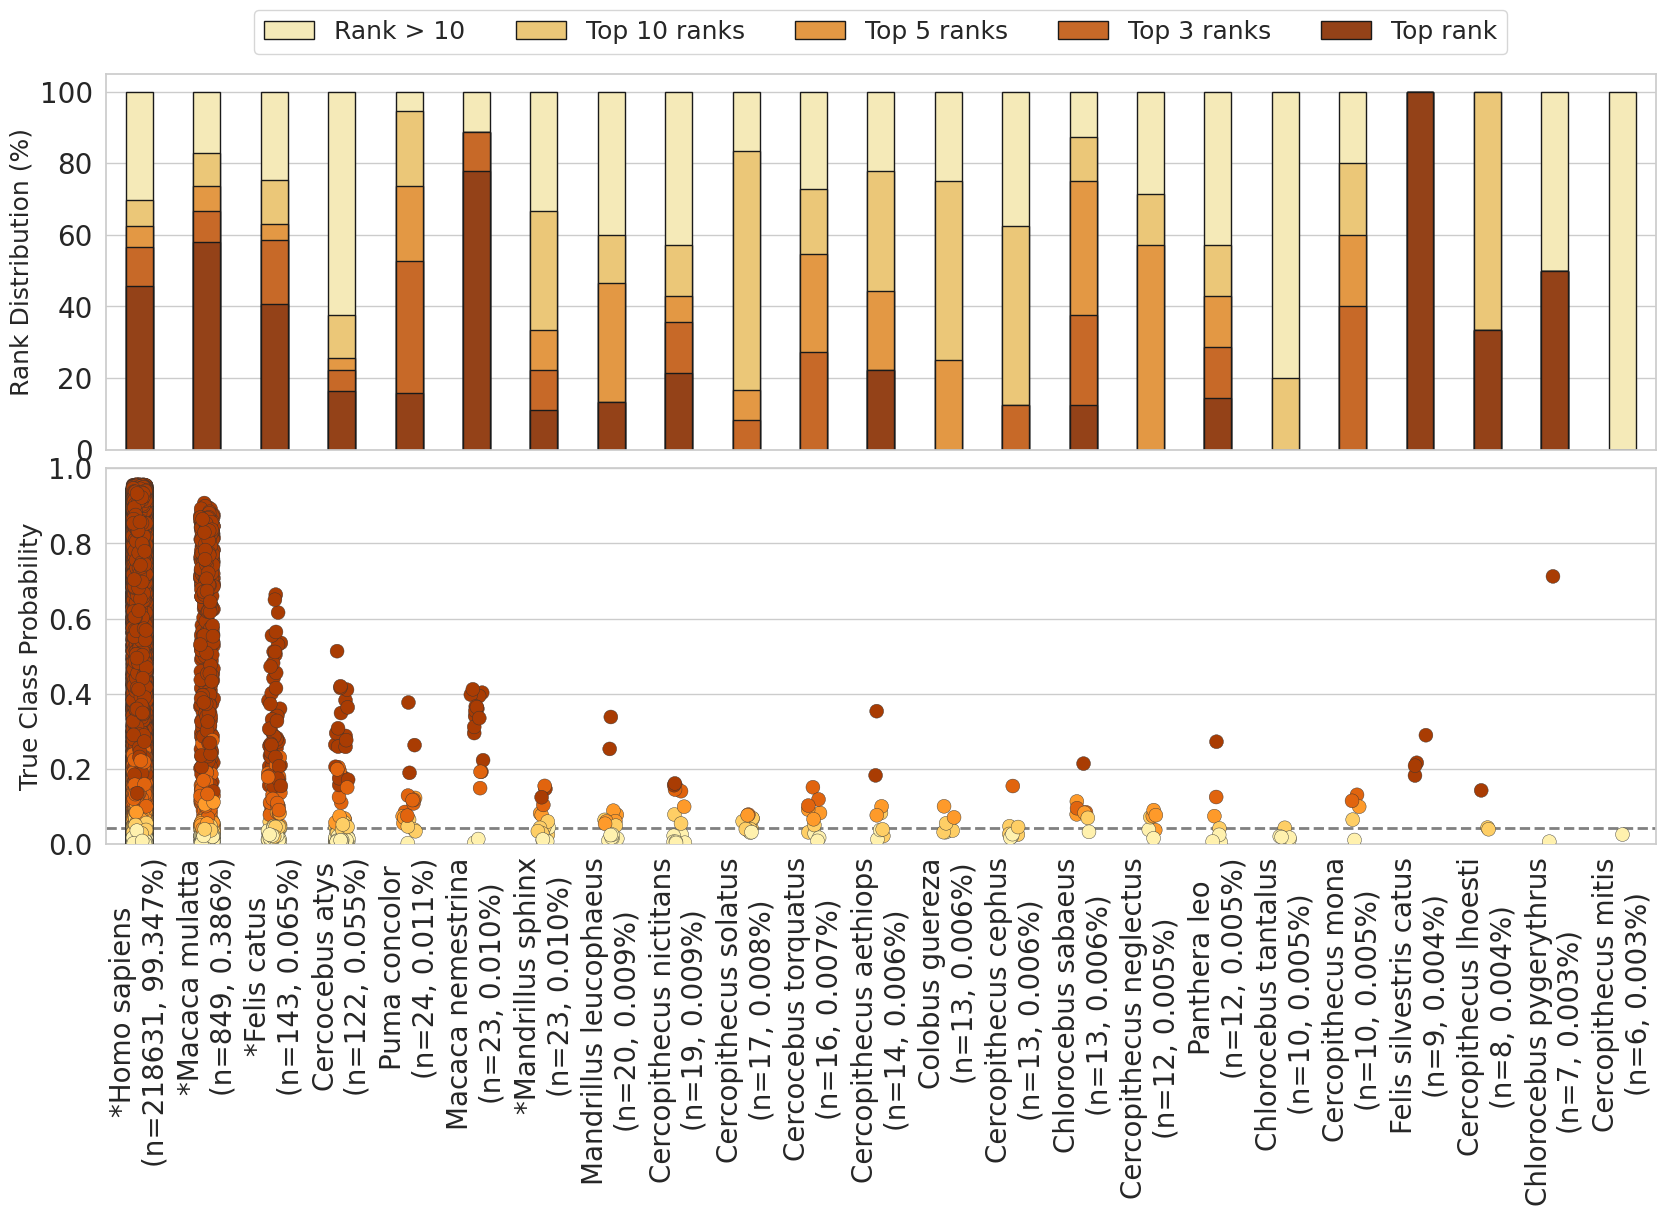

In [132]:
plot_probability_distribution_stripplot_barplot_landscape(class_prob_df_23way, random_predictor_23way, rank_bins, output_file_path = os.path.join(os.getcwd(), "..", "..", "..", f"output/visualization/temp_new/idv_fsl_23way_landscape.pdf"))

class_prob_df_hosts = ['*Homo sapiens\n(n=218631, 99.347%)', '*Macaca mulatta\n(n=849, 0.386%)', '*Felis catus\n(n=143, 0.065%)', 'Cercocebus atys\n(n=122, 0.055%)', 'Puma concolor\n(n=24, 0.011%)', 'Macaca nemestrina\n(n=23, 0.010%)', '*Mandrillus sphinx\n(n=23, 0.010%)', 'Mandrillus leucophaeus\n(n=20, 0.009%)', 'Cercopithecus nictitans\n(n=19, 0.009%)', 'Cercopithecus solatus\n(n=17, 0.008%)', 'Cercocebus torquatus\n(n=16, 0.007%)', 'Cercopithecus aethiops\n(n=14, 0.006%)', 'Colobus guereza\n(n=13, 0.006%)', 'Cercopithecus cephus\n(n=13, 0.006%)', 'Chlorocebus sabaeus\n(n=13, 0.006%)', 'Cercopithecus neglectus\n(n=12, 0.005%)', 'Panthera leo\n(n=12, 0.005%)', 'Chlorocebus tantalus\n(n=10, 0.005%)', 'Cercopithecus mona\n(n=10, 0.005%)', 'Felis silvestris catus\n(n=9, 0.004%)', 'Cercopithecus lhoesti\n(n=8, 0.004%)', 'Chlorocebus pygerythrus\n(n=7, 0.003%)', 'Cercopithecus mitis\n(n=6, 0.003%)']
number of class_prob_df_hosts = 23


/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/tmp/ipykernel_4044198/3625254298.py:38: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.lineplot(data=lineplot_df, y="percent", x="index", hue="y_true_rank_bin", palette=color_palette, ax=ax[1], legend=False, linewidth=3)
/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/blessyantony/miniconda3/envs/zoonosis/lib

<Figure size 640x480 with 0 Axes>

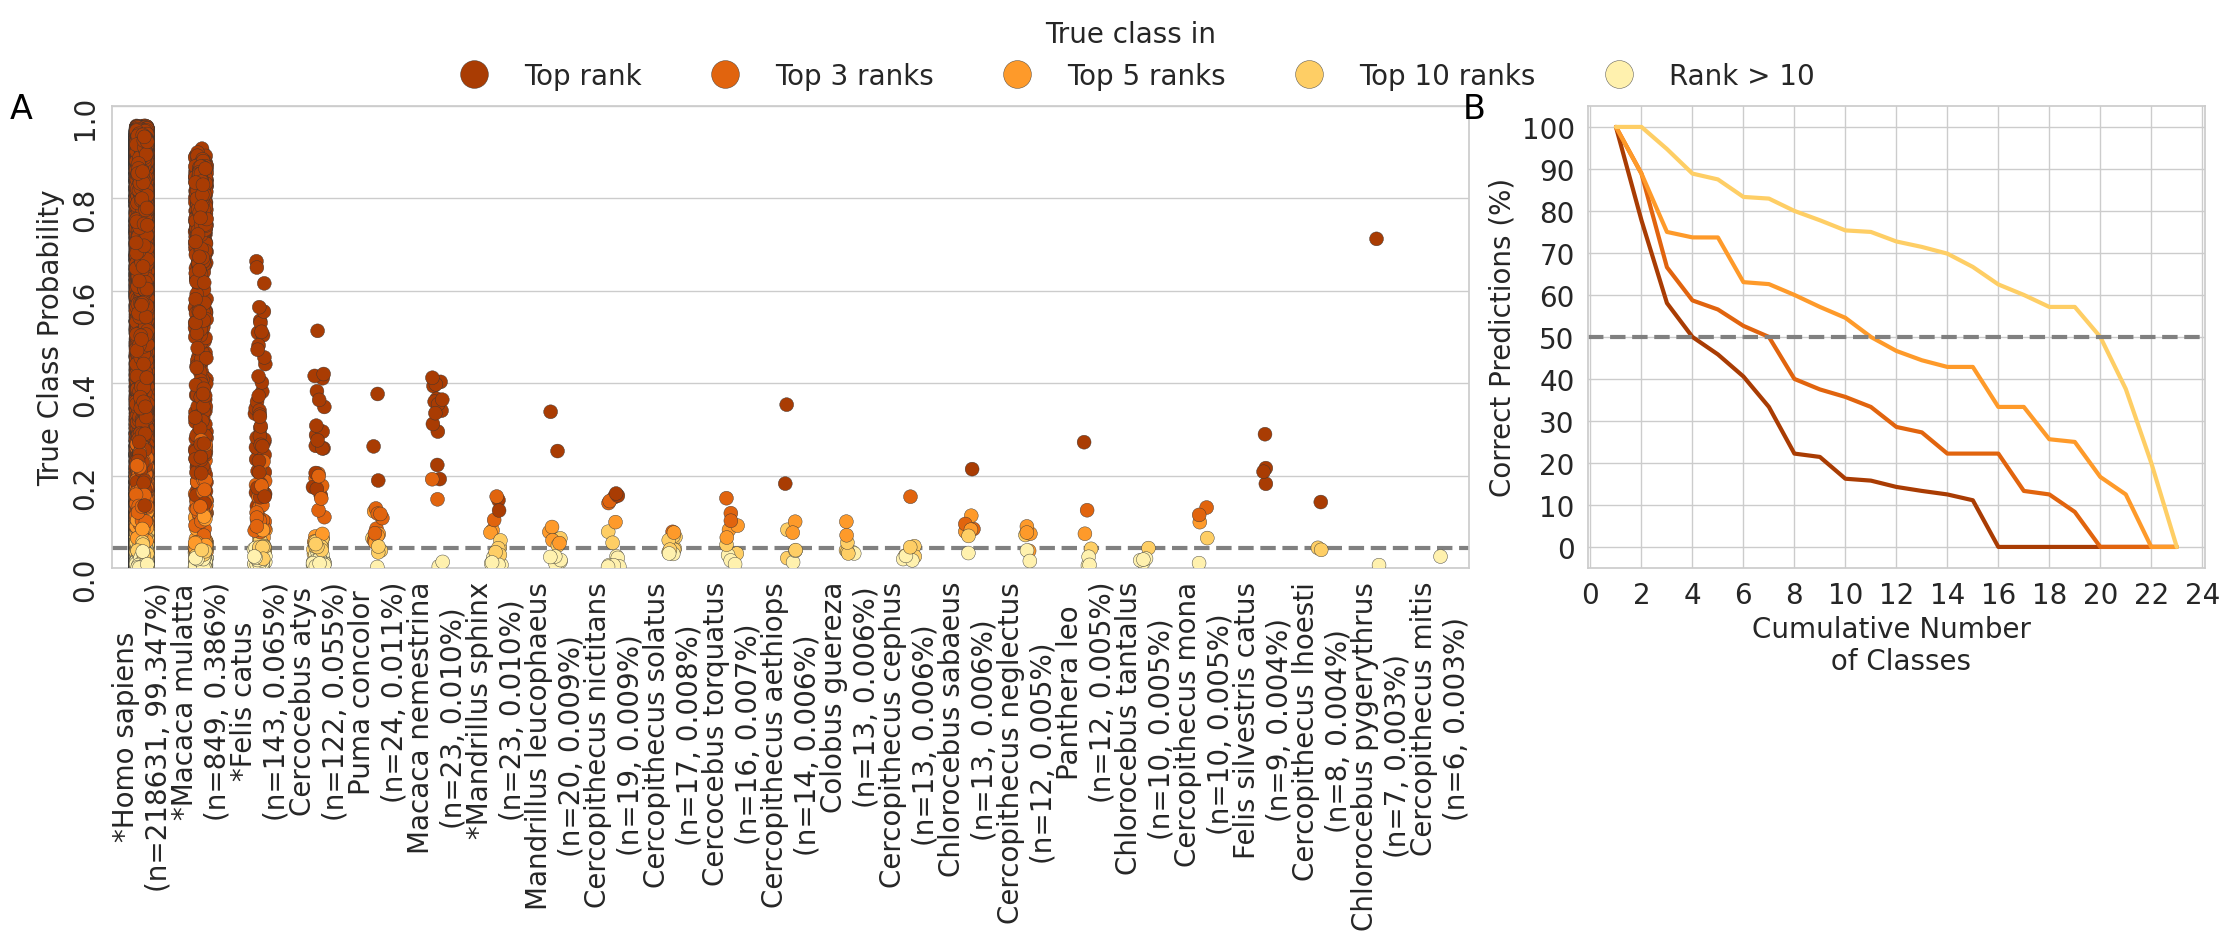

In [25]:
lineplot_df = plot_probability_distribution_stripplot_lineplot(class_prob_df_23way, rank_bins, output_file_path=os.path.join(os.getcwd(), "..", "..", "..", f"output/visualization/temp_new/idv_fsl_23way_stripplot_lineplot.png"))

/tmp/ipykernel_4044198/3366108112.py:12: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.lineplot(data=lineplot_df, y="percent", x="index", hue="y_true_rank_bin", palette=color_palette, ax=ax, linewidth=3)
/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11/site-

<Figure size 640x480 with 0 Axes>

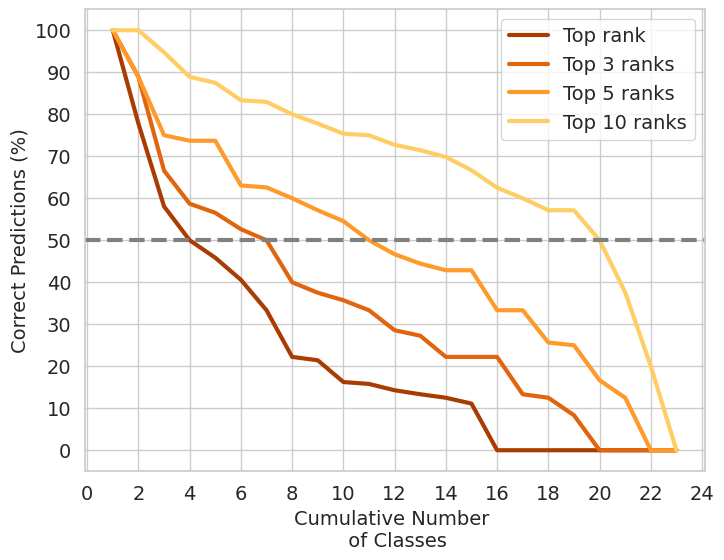

In [27]:
plot_class_proportion_cumulative_nclasses(lineplot_df, rank_bins, output_file_path=os.path.join(os.getcwd(), "..", "..", "..", f"output/visualization/temp_new/idv_fsl_23way_class_proportion_cumulative_nclasses_lineplot.pdf"))

In [28]:
#lineplot_df[lineplot_df["index"] == 19]
print(lineplot_df[(lineplot_df["percent"] >= 50) & (lineplot_df["y_true_rank_bin"] == "Top 10 ranks")])

    index                                    class y_true_rank_bin  \
0       1     Cercopithecus lhoesti\n(n=8, 0.004%)    Top 10 ranks   
1       2    Felis silvestris catus\n(n=9, 0.004%)    Top 10 ranks   
2       3            Puma concolor\n(n=24, 0.011%)    Top 10 ranks   
3       4        Macaca nemestrina\n(n=23, 0.010%)    Top 10 ranks   
4       5      Chlorocebus sabaeus\n(n=13, 0.006%)    Top 10 ranks   
5       6    Cercopithecus solatus\n(n=17, 0.008%)    Top 10 ranks   
6       7         *Macaca mulatta\n(n=849, 0.386%)    Top 10 ranks   
7       8       Cercopithecus mona\n(n=10, 0.005%)    Top 10 ranks   
8       9   Cercopithecus aethiops\n(n=14, 0.006%)    Top 10 ranks   
9      10            *Felis catus\n(n=143, 0.065%)    Top 10 ranks   
10     11          Colobus guereza\n(n=13, 0.006%)    Top 10 ranks   
11     12     Cercocebus torquatus\n(n=16, 0.007%)    Top 10 ranks   
12     13  Cercopithecus neglectus\n(n=12, 0.005%)    Top 10 ranks   
13     14       *Hom

#### 167-way

In [119]:
#output_file_path =  os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_idv_unseen_hosts/20241010/host_multi/few_shot_learning/fsl_tr_w3s5q10_ev_walls5q-1_tsk1e1b16itr5_split70-10-20-gpu2_hybrid-attention_sl256st64vs30_ae_bn_fnn_2l_d1024_lr1e-4_output.csv")
#auprc_file_path =  os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_idv_unseen_hosts/20241010/host_multi/few_shot_learning/fsl_tr_w3s5q10_ev_walls5q-1_tsk1e1b16itr5_split70-10-20-gpu2_hybrid-attention_sl256st64vs30_ae_bn_fnn_2l_d1024_lr1e-4_classwise_auprc.csv")
output_file_path =  os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_idv_all_hosts/20241022/host_multi/few_shot_learning/fsl_tr_w3s5q10_ev_walls5q-1_tsk1e1b16itr5_split70-10-20-gpu2_hybrid-attention_sl256st64vs30_ae_bn_fnn_2l_d1024_lr1e-4_output.csv")
auprc_file_path =  os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_idv_all_hosts/20241022/host_multi/few_shot_learning/fsl_tr_w3s5q10_ev_walls5q-1_tsk1e1b16itr5_split70-10-20-gpu2_hybrid-attention_sl256st64vs30_ae_bn_fnn_2l_d1024_lr1e-4_classwise_auprc.csv")


In [120]:
def get_rank_bin(row):
    rank = row["y_true_rank"]
    if rank == 1:
        return "Top Rank"
    elif rank <= 5:
        return "Top 5 ranks"
    elif rank <= 10:
        return "Top 10 ranks"
    elif rank <= 15:
        return "Top 15 ranks"
    elif rank <= 20:
        return "Top 20 ranks"
    else:
        return "Rank > 20"
    
rank_bins = ["Top Rank", "Top 5 ranks", "Top 10 ranks", "Top 15 ranks", "Top 20 ranks", "Rank > 20"]

In [121]:
class_prob_df_167way, random_predictor_167way, idv_seen_hosts, idv_unseen_hosts = analyze_all_way_fsl_results(output_file_path, auprc_file_path)

Number of unique classes in output_df = 167
Number of unique labels in output_df = 167


/tmp/ipykernel_3646117/265477895.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df.drop(columns="itr", inplace=True)
/tmp/ipykernel_3646117/265477895.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df["y_true_rank"] = sub_df.apply(lambda x: get_rank(x, all_output_labels), axis=1)
/tmp/ipykernel_3646117/265477895.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Number of Unseen IDV hosts  =  32
Number of Seen IDV hosts  =  8


class_prob_df_hosts = ['*Homo sapiens\n(n=218631, 99.347%)', '*Macaca mulatta\n(n=849, 0.386%)', '*Felis catus\n(n=143, 0.065%)', 'Cercocebus atys\n(n=122, 0.055%)', 'Puma concolor\n(n=24, 0.011%)', 'Macaca nemestrina\n(n=23, 0.010%)', '*Mandrillus sphinx\n(n=23, 0.010%)', 'Mandrillus leucophaeus\n(n=20, 0.009%)', 'Cercopithecus nictitans\n(n=19, 0.009%)', 'Cercopithecus solatus\n(n=17, 0.008%)', 'Cercocebus torquatus\n(n=16, 0.007%)', 'Cercopithecus aethiops\n(n=14, 0.006%)', 'Colobus guereza\n(n=13, 0.006%)', 'Cercopithecus cephus\n(n=13, 0.006%)', 'Chlorocebus sabaeus\n(n=13, 0.006%)', 'Cercopithecus neglectus\n(n=12, 0.005%)', 'Panthera leo\n(n=12, 0.005%)', 'Chlorocebus tantalus\n(n=10, 0.005%)', 'Cercopithecus mona\n(n=10, 0.005%)', 'Felis silvestris catus\n(n=9, 0.004%)', 'Cercopithecus lhoesti\n(n=8, 0.004%)', 'Chlorocebus pygerythrus\n(n=7, 0.003%)', 'Cercopithecus mitis\n(n=6, 0.003%)', '*Macaca fascicularis\n(n=5, 0.002%)', '*Felis domesticus\n(n=5, 0.002%)', '*Macaca arctoi

/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

<Figure size 640x480 with 0 Axes>

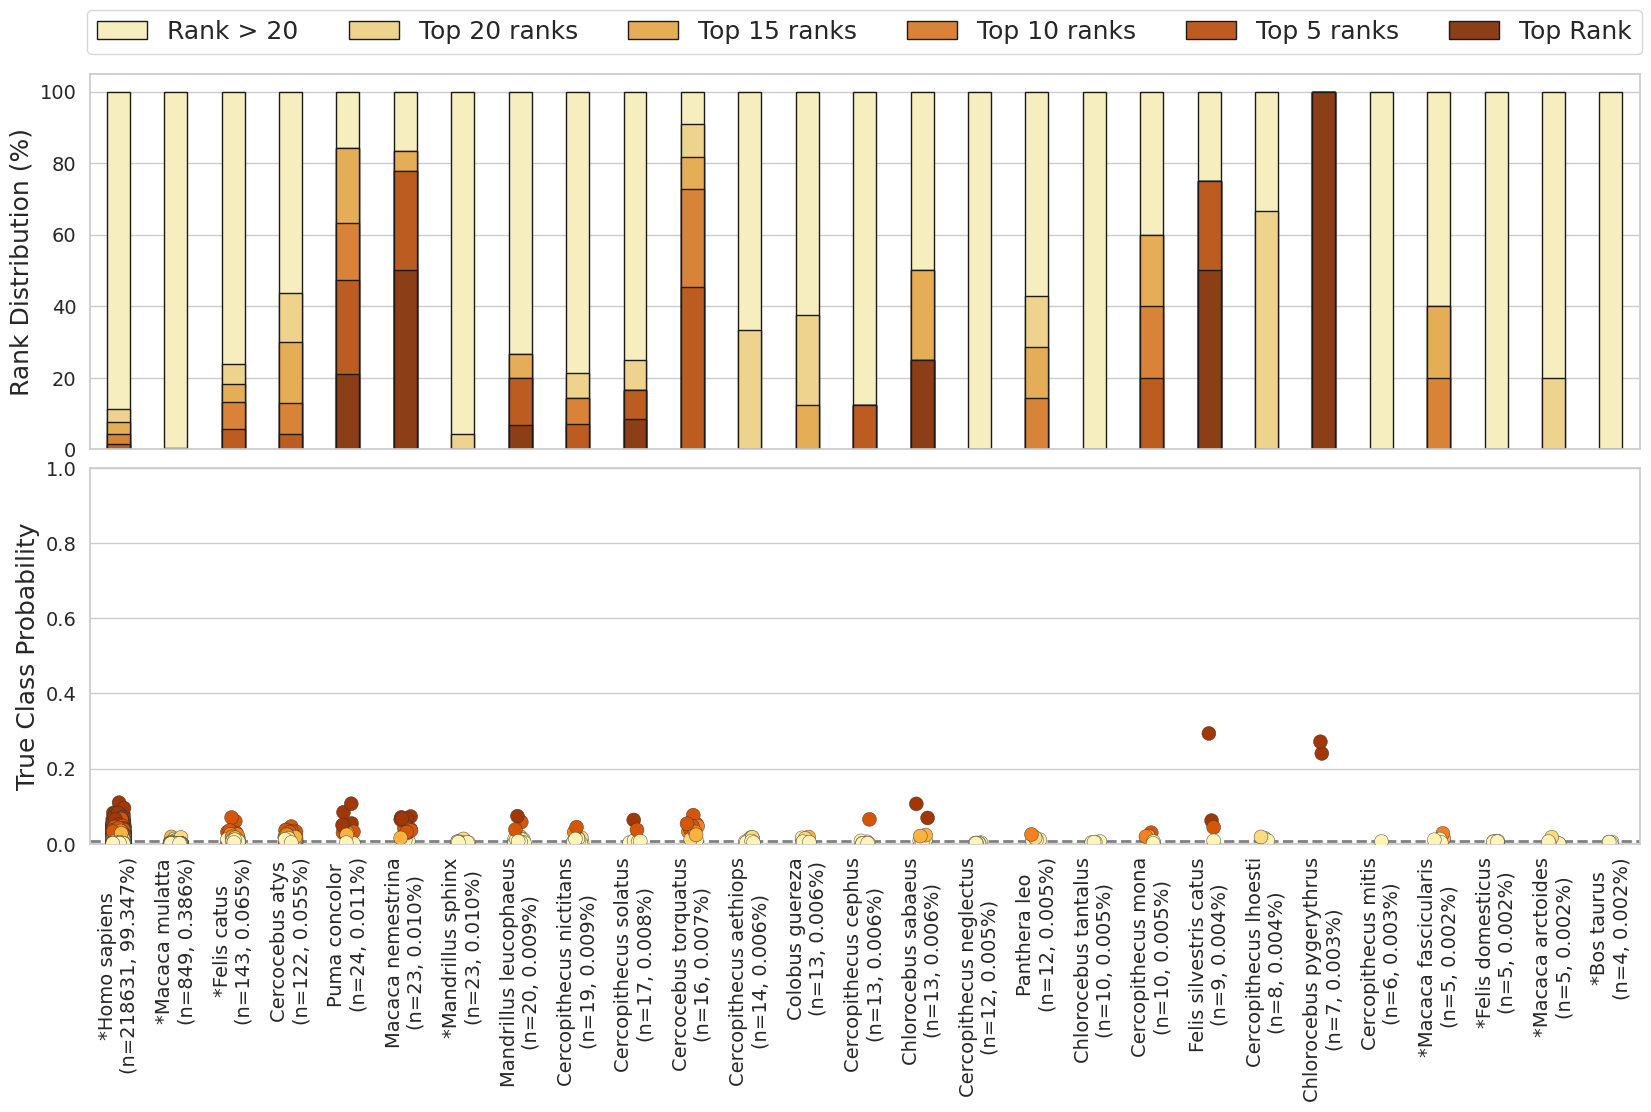

In [122]:
plot_probability_distribution_stripplot_barplot_landscape(class_prob_df_167way, random_predictor_167way, rank_bins, output_file_path = os.path.join(os.getcwd(), "..", "..", "..", f"output/visualization/temp_new/idv_fsl_167way_landscape.png"))

class_prob_df_hosts = ['*Homo sapiens\n(n=218631, 99.347%)', '*Macaca mulatta\n(n=849, 0.386%)', '*Felis catus\n(n=143, 0.065%)', 'Cercocebus atys\n(n=122, 0.055%)', 'Puma concolor\n(n=24, 0.011%)', 'Macaca nemestrina\n(n=23, 0.010%)', '*Mandrillus sphinx\n(n=23, 0.010%)', 'Mandrillus leucophaeus\n(n=20, 0.009%)', 'Cercopithecus nictitans\n(n=19, 0.009%)', 'Cercopithecus solatus\n(n=17, 0.008%)', 'Cercocebus torquatus\n(n=16, 0.007%)', 'Cercopithecus aethiops\n(n=14, 0.006%)', 'Colobus guereza\n(n=13, 0.006%)', 'Cercopithecus cephus\n(n=13, 0.006%)', 'Chlorocebus sabaeus\n(n=13, 0.006%)', 'Cercopithecus neglectus\n(n=12, 0.005%)', 'Panthera leo\n(n=12, 0.005%)', 'Chlorocebus tantalus\n(n=10, 0.005%)', 'Cercopithecus mona\n(n=10, 0.005%)', 'Felis silvestris catus\n(n=9, 0.004%)', 'Cercopithecus lhoesti\n(n=8, 0.004%)', 'Chlorocebus pygerythrus\n(n=7, 0.003%)', 'Cercopithecus mitis\n(n=6, 0.003%)', '*Macaca fascicularis\n(n=5, 0.002%)', '*Felis domesticus\n(n=5, 0.002%)', '*Macaca arctoi

/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

<Figure size 640x480 with 0 Axes>

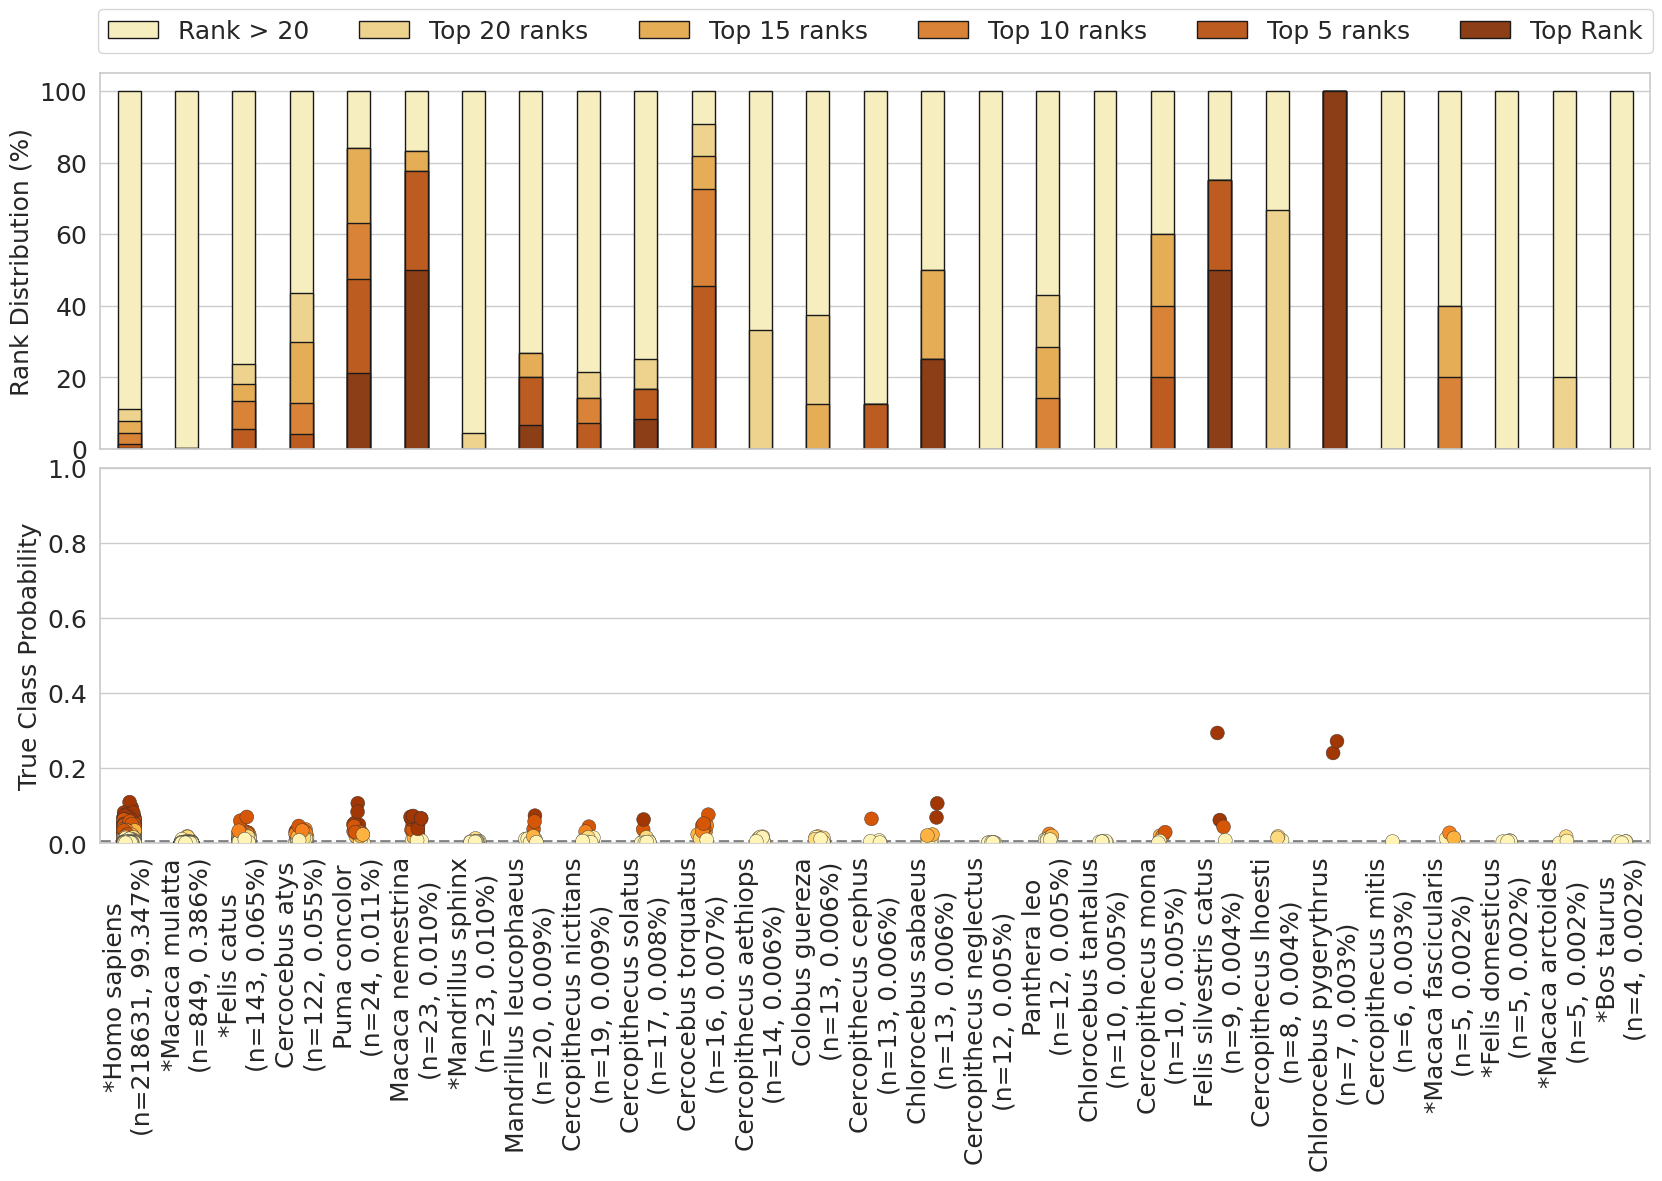

In [123]:
plot_probability_distribution_stripplot_barplot_landscape(class_prob_df_167way, random_predictor_167way, rank_bins, output_file_path = os.path.join(os.getcwd(), "..", "..", "..", f"output/visualization/temp_new/idv_fsl_167way_landscape.pdf"))

class_prob_df_hosts = ['*Homo sapiens\n(n=218631, 99.347%)', '*Macaca mulatta\n(n=849, 0.386%)', '*Felis catus\n(n=143, 0.065%)', 'Cercocebus atys\n(n=122, 0.055%)', 'Puma concolor\n(n=24, 0.011%)', 'Macaca nemestrina\n(n=23, 0.010%)', '*Mandrillus sphinx\n(n=23, 0.010%)', 'Mandrillus leucophaeus\n(n=20, 0.009%)', 'Cercopithecus nictitans\n(n=19, 0.009%)', 'Cercopithecus solatus\n(n=17, 0.008%)', 'Cercocebus torquatus\n(n=16, 0.007%)', 'Cercopithecus aethiops\n(n=14, 0.006%)', 'Colobus guereza\n(n=13, 0.006%)', 'Cercopithecus cephus\n(n=13, 0.006%)', 'Chlorocebus sabaeus\n(n=13, 0.006%)', 'Cercopithecus neglectus\n(n=12, 0.005%)', 'Panthera leo\n(n=12, 0.005%)', 'Chlorocebus tantalus\n(n=10, 0.005%)', 'Cercopithecus mona\n(n=10, 0.005%)', 'Felis silvestris catus\n(n=9, 0.004%)', 'Cercopithecus lhoesti\n(n=8, 0.004%)', 'Chlorocebus pygerythrus\n(n=7, 0.003%)', 'Cercopithecus mitis\n(n=6, 0.003%)', '*Macaca fascicularis\n(n=5, 0.002%)', '*Felis domesticus\n(n=5, 0.002%)', '*Macaca arctoi

/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/tmp/ipykernel_3646117/4265495919.py:38: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.lineplot(data=lineplot_df, y="percent", x="index", hue="y_true_rank_bin", palette=color_palette, ax=ax[1], legend=False, linewidth=3)
/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/blessyantony/miniconda3/envs/zoonosis/lib

<Figure size 640x480 with 0 Axes>

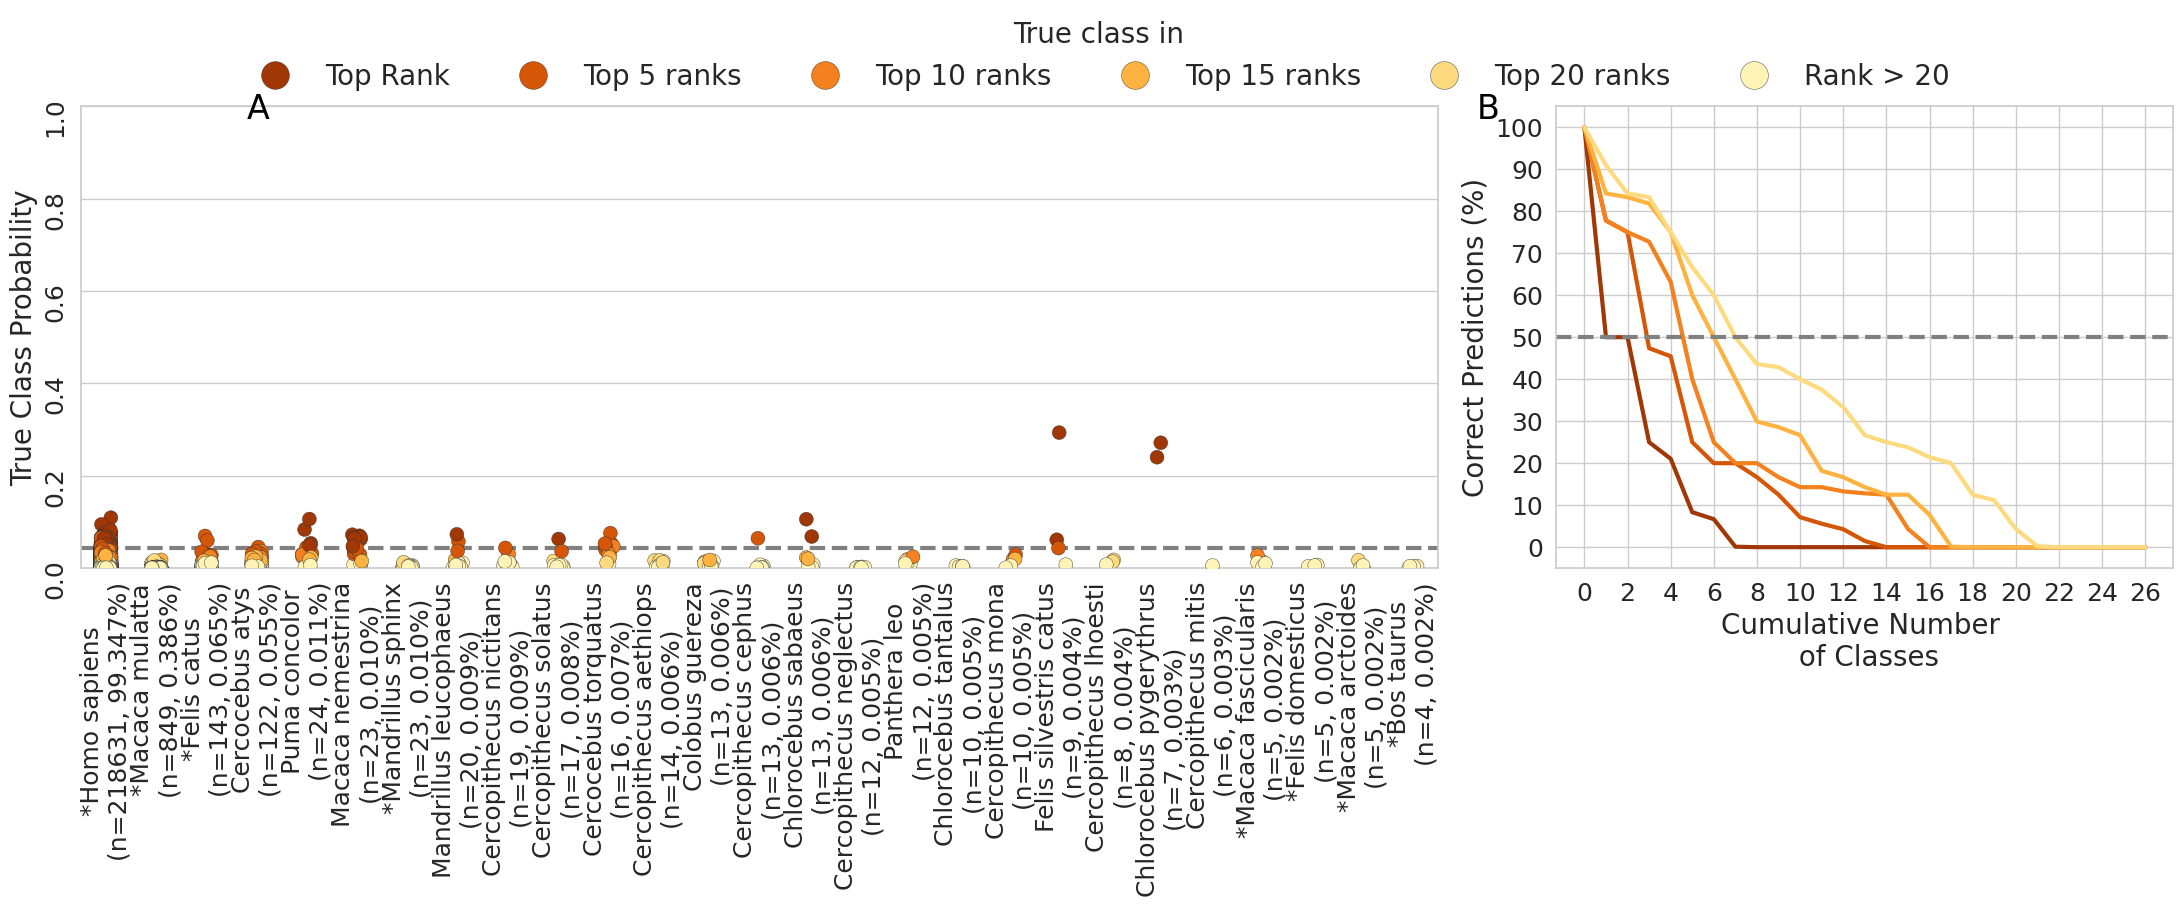

In [124]:
lineplot_df = plot_probability_distribution_stripplot_lineplot(class_prob_df_167way, rank_bins, output_file_path=os.path.join(os.getcwd(), "..", "..", "..", f"output/visualization/temp_new/idv_fsl_167way_stripplot_lineplot.png"))

/tmp/ipykernel_3646117/3366108112.py:12: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.lineplot(data=lineplot_df, y="percent", x="index", hue="y_true_rank_bin", palette=color_palette, ax=ax, linewidth=3)
/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11/site-

<Figure size 640x480 with 0 Axes>

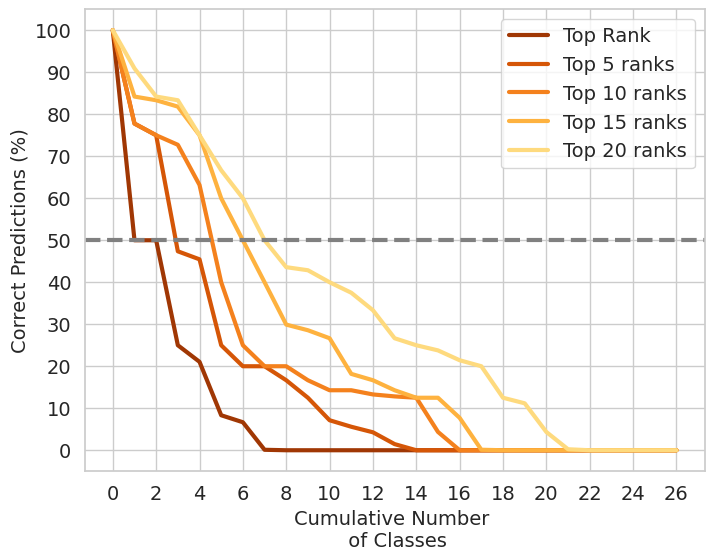

In [127]:
plot_class_proportion_cumulative_nclasses(lineplot_df, rank_bins, output_file_path=os.path.join(os.getcwd(), "..", "..", "..", f"output/visualization/temp_new/idv_fsl_167way_class_proportion_cumulative_nclasses_lineplot.pdf"))